In [1]:
!pip install kagglehub


In [3]:
from google.colab import files
files.upload()  # Upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ramgunjal","key":"6101103a412b9880c21c0c415313dfb9"}'}

In [4]:
import os
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json


In [5]:
!kaggle datasets download -d lakshmi25npathi/online-retail-dataset
!unzip online-retail-dataset.zip


Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/online-retail-dataset
License(s): other
  0% 0.00/43.3M [00:00<?, ?B/s]
100% 43.3M/43.3M [00:00<00:00, 1.11GB/s]
Archive:  online-retail-dataset.zip
  inflating: online_retail_II.xlsx   


In [6]:
import pandas as pd

# Load the dataset into a DataFrame
df = pd.read_excel("online_retail_II.xlsx")

# Display the first few rows to confirm it's loaded
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [7]:
pip install lifetimes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 16.1 MB/s eta 0:00:00


**Load and Prepare the Data**

In [8]:
import pandas as pd
import numpy as np
from datetime import datetime
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.plotting import plot_period_transactions, plot_calibration_purchases_vs_holdout_purchases

# Load the dataset
df = pd.read_excel("online_retail_II.xlsx", sheet_name="Year 2010-2011")

# --- Data Cleaning ---

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Drop rows with missing CustomerID, as they cannot be tracked
df.dropna(subset=['Customer ID'], inplace=True)

# Ensure CustomerID is an integer
df['Customer ID'] = df['Customer ID'].astype(int)

# Remove returns (invoices starting with 'C' or having negative quantity)
df = df[~df['Invoice'].str.contains('C', na=False)]
df = df[df['Quantity'] > 0]
df = df[df['Price'] > 0]

# Calculate total sales for each transaction
df['TotalSales'] = df['Quantity'] * df['Price']

print("Data after cleaning:")
print(df.head())
print(f"\nData shape: {df.shape}")
print(f"Date range: {df['InvoiceDate'].min()} to {df['InvoiceDate'].max()}")

Data after cleaning:
  Invoice StockCode                          Description  Quantity  \
0  536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1  536365     71053                  WHITE METAL LANTERN         6   
2  536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3  536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4  536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  Price  Customer ID         Country  TotalSales  
0 2010-12-01 08:26:00   2.55        17850  United Kingdom       15.30  
1 2010-12-01 08:26:00   3.39        17850  United Kingdom       20.34  
2 2010-12-01 08:26:00   2.75        17850  United Kingdom       22.00  
3 2010-12-01 08:26:00   3.39        17850  United Kingdom       20.34  
4 2010-12-01 08:26:00   3.39        17850  United Kingdom       20.34  

Data shape: (397885, 9)
Date range: 2010-12-01 08:26:00 to 2011-12-09 12:50:00


**Feature Engineering for CLV Models (RFM-T)**

In [9]:
# Setting the end of the observation period (a day after the last transaction)
observation_date = df['InvoiceDate'].max() + pd.DateOffset(days=1)

# Create the summary data required by the lifetimes library
clv_df = summary_data_from_transaction_data(
    df,
    customer_id_col='Customer ID',
    datetime_col='InvoiceDate',
    monetary_value_col='TotalSales',
    observation_period_end=observation_date
)

print("\nRFM-T Summary Data:")
print(clv_df.head())


RFM-T Summary Data:
             frequency  recency      T  monetary_value
Customer ID                                           
12346              0.0      0.0  326.0        0.000000
12347              6.0    365.0  368.0      599.701667
12348              3.0    283.0  359.0      301.480000
12349              0.0      0.0   19.0        0.000000
12350              0.0      0.0  311.0        0.000000


**Train the BG/NBD Model**

In [16]:
from lifetimes import BetaGeoFitter

# We're increasing the penalizerto a stronger value of 0.1
penalizer_value = 0.1

bgf = BetaGeoFitter(penalizer_coef=penalizer_value)
bgf.fit(clv_df['frequency'], clv_df['recency'], clv_df['T'])

print(f"Model successfully converged with penalizer_coef = {penalizer_value}")


print("\nBG/NBD Model Summary:")
print(bgf.summary)

# Predict the number of purchases a customer will make in the next 90 days
t = 90
clv_df['predicted_purchases_90d'] = bgf.predict(t, clv_df['frequency'], clv_df['recency'], clv_df['T'])

print("\nDataFrame with Predicted Purchases:")
print(clv_df.sort_values(by='predicted_purchases_90d', ascending=False).head())

Model successfully converged with penalizer_coef = 0.1

BG/NBD Model Summary:
               coef      se(coef)  lower 95% bound  upper 95% bound
r      5.933141e-01  1.479488e-02     5.643162e-01     6.223121e-01
alpha  4.970836e+01  1.646554e+00     4.648112e+01     5.293561e+01
a      8.082354e-18  5.151183e-12    -1.009631e-11     1.009633e-11
b      3.429131e-08  2.185461e-02    -4.283500e-02     4.283507e-02

DataFrame with Predicted Purchases:
             frequency  recency      T  monetary_value  \
Customer ID                                              
14911            131.0    372.0  374.0     1093.661679   
12748            112.0    373.0  374.0      301.024821   
17841            111.0    372.0  374.0      364.452162   
15311             89.0    373.0  374.0      677.729438   
14606             88.0    372.0  374.0      135.890114   

             predicted_purchases_90d  
Customer ID                           
14911                      27.951769  
12748                

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [17]:
import numpy as np

# Check for any NaN (Not a Number) or infinite values in our new prediction column
nan_count = clv_df['predicted_purchases_90d'].isna().sum()
inf_count = np.isinf(clv_df['predicted_purchases_90d']).sum()

print(f"Number of NaN predictions generated: {nan_count}")
print(f"Number of infinite predictions generated: {inf_count}")

# Let's fill any NaN values with 0, as they represent customers the model
# cannot make a prediction for, logically resulting in zero future purchases.
if nan_count > 0:
    clv_df['predicted_purchases_90d'].fillna(0, inplace=True)
    print("Filled NaN values with 0.")

Number of NaN predictions generated: 10
Number of infinite predictions generated: 0
Filled NaN values with 0.


**Train the Gamma-Gamma Model (Predicting Purchase Value)**

In [18]:
from lifetimes import GammaGammaFitter


# The Gamma-Gamma model requires that monetary_value > 0.
# It also works best when frequency and monetary_value are not correlated.
# We will use the subset of customers who have made at least one repeat purchase.
ggf_df = clv_df[clv_df['frequency'] > 0]

print("Checking correlation between frequency and monetary value for Gamma-Gamma model...")
correlation = ggf_df[['frequency', 'monetary_value']].corr().iloc[0, 1]
print(f"Correlation: {correlation:.4f}")

if abs(correlation) > 0.1:
    print("Warning: Correlation is higher than ideal. Results may be slightly biased, but we will proceed.")
else:
    print("Correlation is low, which is good for the model's assumptions.")


# Instantiate and fit the Gamma-Gamma model
# We'll use a small penalizer here as well for stability
ggf = GammaGammaFitter(penalizer_coef=0.001)
ggf.fit(ggf_df['frequency'], ggf_df['monetary_value'])

print("\nGamma-Gamma Model Summary:")
print(ggf.summary)

# Predict the average transaction value for each customer
clv_df['predicted_avg_order_value'] = ggf.conditional_expected_average_profit(
    clv_df['frequency'],
    clv_df['monetary_value']
)

print("\nDataFrame with Predicted Average Order Value:")
# Display the customers with the highest predicted spend per transaction
print(clv_df.sort_values(by='predicted_avg_order_value', ascending=False).head())

Checking correlation between frequency and monetary value for Gamma-Gamma model...
Correlation: 0.0159
Correlation is low, which is good for the model's assumptions.

Gamma-Gamma Model Summary:
        coef  se(coef)  lower 95% bound  upper 95% bound
p  11.125602  0.269274        10.597825        11.653379
q   0.838780  0.019731         0.800107         0.877452
v  11.293018  0.281539        10.741201        11.844836

DataFrame with Predicted Average Order Value:
             frequency  recency      T  monetary_value  \
Customer ID                                              
16446              1.0    205.0  206.0     168469.6000   
15749              1.0     97.0  333.0      21535.9000   
18102             25.0    367.0  368.0       9349.4772   
12536              1.0     16.0   60.0       8322.1200   
12415             15.0    313.0  338.0       7860.2100   

             predicted_purchases_90d  predicted_avg_order_value  
Customer ID                                               

**Calculate the Final CLV**

In [19]:


# First, let's calculate the simple CLV for the next 90 days based on our predictions.
# We need to handle potential NaN values for customers who never made a repeat purchase
# by filling them with 0.
clv_df['clv_predicted_90d'] = clv_df['predicted_purchases_90d'] * clv_df['predicted_avg_order_value']
clv_df.fillna(0, inplace=True)


# For a more robust CLV, we use the library's built-in function which also
# incorporates a discount rate. A discount rate accounts for the fact that
# money in the future is worth less than money today.
# Let's calculate a 12-month CLV with a monthly discount rate of 1% (annual ~12%).
clv_df['clv_1_year_discounted'] = ggf.customer_lifetime_value(
    bgf, # The BG/NBD model we trained
    clv_df['frequency'],
    clv_df['recency'],
    clv_df['T'],
    clv_df['monetary_value'],
    time=12,                 # 12 months prediction horizon
    discount_rate=0.01       # 1% monthly discount rate
)


# --- Display the Final Results ---
print("--- Top 15 Customers by Predicted 1-Year CLV ---")

# Sort the dataframe by the 1-year discounted CLV to see our most valuable customers
final_clv_report = clv_df.sort_values(by='clv_1_year_discounted', ascending=False)

# Display the most important columns for our final report
print(final_clv_report[['frequency', 'monetary_value', 'clv_predicted_90d', 'clv_1_year_discounted']].head(15))

--- Top 15 Customers by Predicted 1-Year CLV ---
             frequency  monetary_value  clv_predicted_90d  \
Customer ID                                                 
16446              1.0   168469.600000       95871.388388   
14646             44.0     6366.705909       63160.481658   
18102             25.0     9349.477200       51588.866297   
17450             26.0     7404.690385       42453.773816   
14096             16.0     4071.434375       40121.980325   
14911            131.0     1093.661679       30575.570565   
12415             15.0     7860.210000       28482.051925   
14156             42.0     2787.081667       25346.219353   
17511             27.0     3305.060741       19384.155816   
16029             38.0     2034.808421       16689.377809   
16684             15.0     4394.286667       15106.016668   
13694             34.0     1888.161765       13882.522078   
15311             89.0      677.729438       12902.071616   
13089             65.0      893.7143

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


📊Insights From Table:
1. Customer 16446 – The "Whale"
1 order, but extremely high spend

Strategy: Investigate; this could be a B2B client or outlier

2. Customer 14646 – The Ideal VIP
44 purchases, high value

Strategy: Treat like royalty — loyalty rewards, early access, personalization

3. Customer 18102 – The High-Roller
Fewer purchases than 14646, but much higher average spend

Strategy: Upsell/cross-sell high-end items

4. Customer 14911 – The Super-Fan
Very frequent but smaller spend per order

Strategy: Consider subscriptions or bulk deals

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a professional plot style
sns.set_style("whitegrid")

**The Distribution of Customer Lifetime Value**

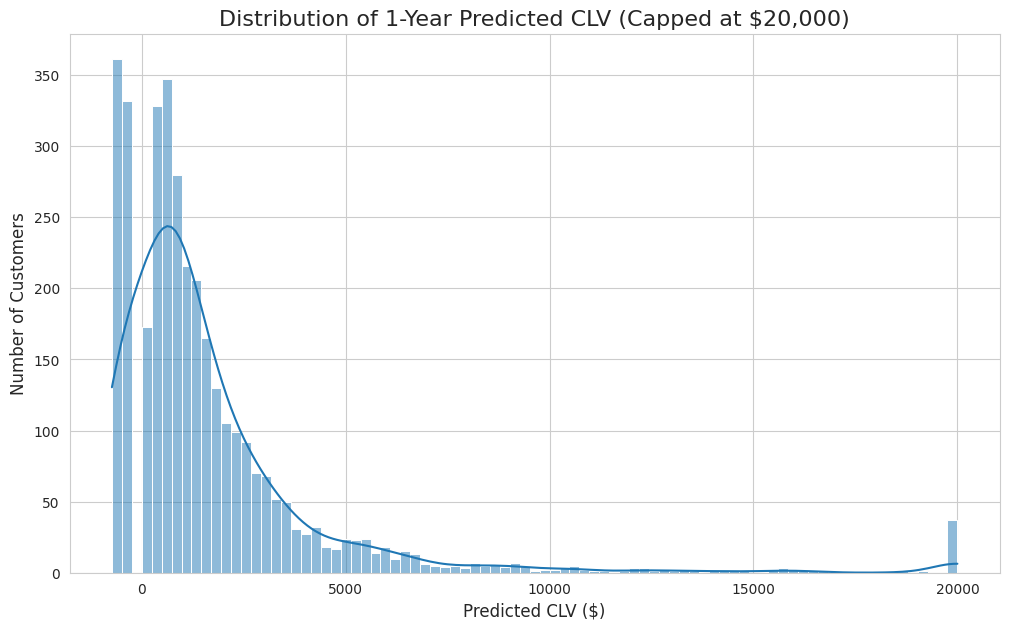

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Visualization 1: Distribution of 1-Year Predicted CLV ---

# The CLV data is heavily skewed, with a few super-valuable customers.
# To make the plot readable, we will cap the CLV for visualization purposes.
# This helps us see the distribution of the "main body" of customers without
# the extreme outliers squishing the x-axis.
plot_df = clv_df.copy()
clv_cap = 20000
plot_df.loc[plot_df['clv_1_year_discounted'] > clv_cap, 'clv_1_year_discounted'] = clv_cap

plt.figure(figsize=(12, 7))
sns.histplot(plot_df['clv_1_year_discounted'], kde=True)
plt.title(f'Distribution of 1-Year Predicted CLV (Capped at ${clv_cap:,})', fontsize=16)
plt.xlabel('Predicted CLV ($)', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.show()

**Visualize Model Predictions (How the Model "Thinks")**

Plotting Model Prediction Matrices...


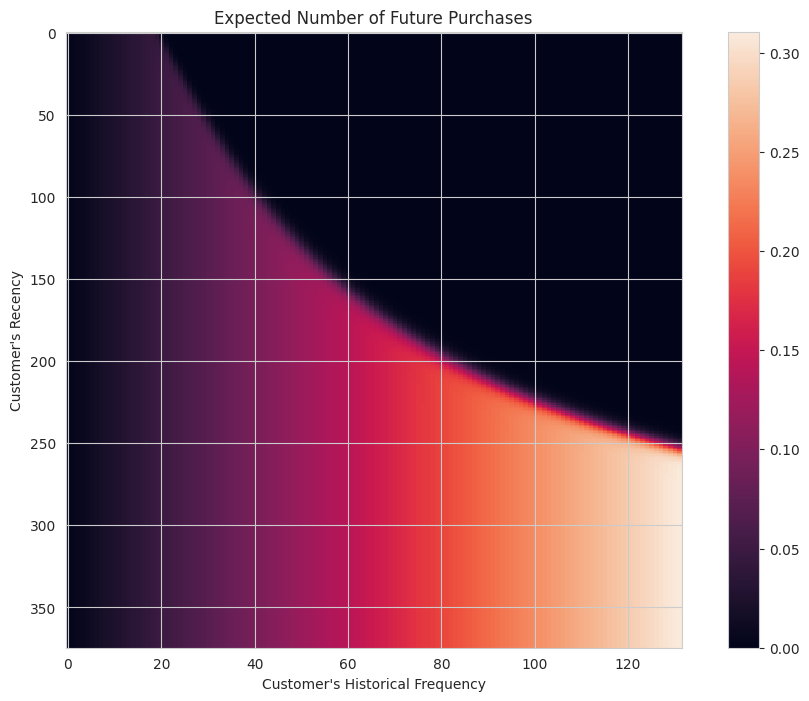

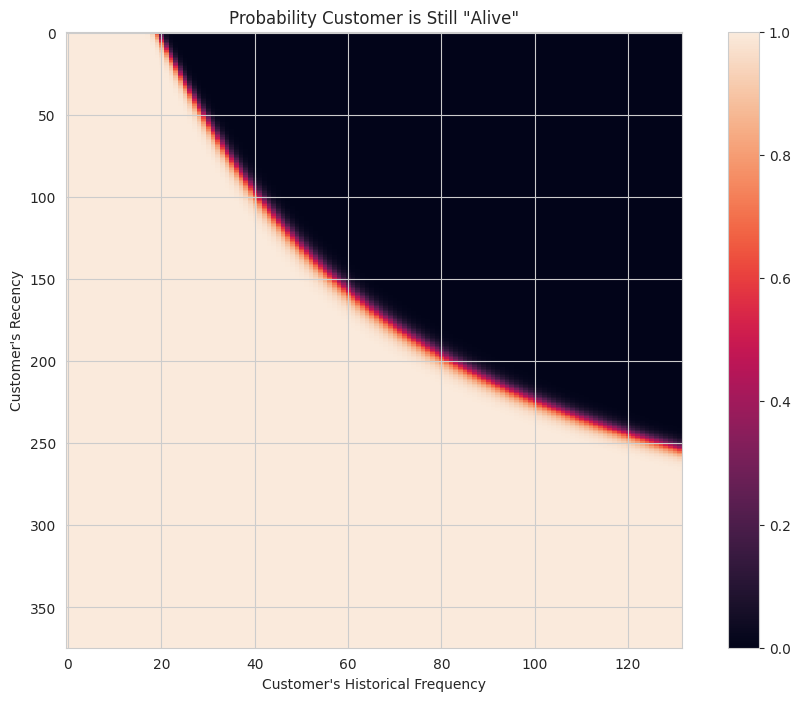

In [25]:
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix

print("Plotting Model Prediction Matrices...")

# --- Frequency/Recency Matrix ---
# Shows the expected number of future purchases
plt.figure(figsize=(12, 8))
plot_frequency_recency_matrix(bgf)
plt.title('Expected Number of Future Purchases')
plt.show()

# --- Probability Alive Matrix ---
# Shows the probability that a customer is still "alive" (has not churned)
plt.figure(figsize=(12, 8))
plot_probability_alive_matrix(bgf)
plt.title('Probability Customer is Still "Alive"')
plt.show()

**Visualize Final CLV Results (The "Money" Shot)**

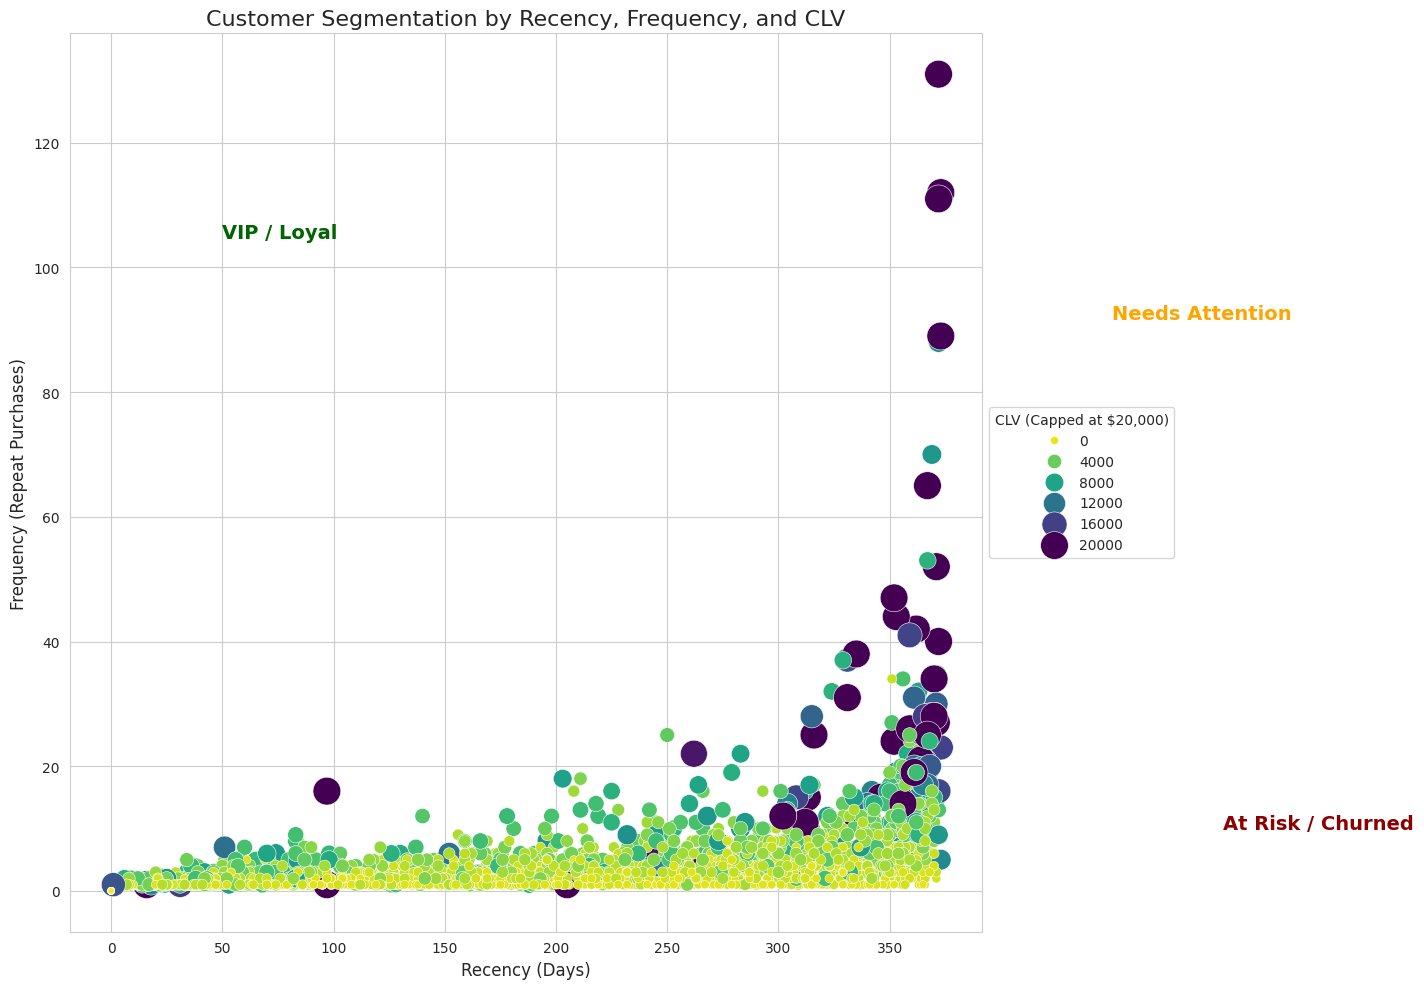

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Visualization 3: Recency vs. Frequency (Colored by CLV) ---

# We'll use the same capped data for better color mapping in the plot
plot_df = clv_df.copy()
clv_cap = 20000
plot_df.loc[plot_df['clv_1_year_discounted'] > clv_cap, 'clv_1_year_discounted'] = clv_cap

plt.figure(figsize=(15, 10))

# Create the scatter plot
ax = sns.scatterplot(
    data=plot_df,
    x='recency',
    y='frequency',
    hue='clv_1_year_discounted',
    size='clv_1_year_discounted',
    sizes=(20, 400), # Makes the dot size proportional to CLV
    palette='viridis_r', # Reversed colormap so high values are dark and pop
    legend='auto'
)

plt.title('Customer Segmentation by Recency, Frequency, and CLV', fontsize=16)
plt.xlabel('Recency (Days)', fontsize=12)
plt.ylabel('Frequency (Repeat Purchases)', fontsize=12)

# Add annotations to explain the segments
plt.text(50, plot_df['frequency'].max() * 0.8, 'VIP / Loyal', fontsize=14, color='darkgreen', weight='bold')
plt.text(450, plot_df['frequency'].max() * 0.7, 'Needs Attention', fontsize=14, color='orange', weight='bold')
plt.text(500, 10, 'At Risk / Churned', fontsize=14, color='darkred', weight='bold')

# Move the legend outside the plot for better readability
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title=f'CLV (Capped at ${clv_cap:,})')

# Adjust layout to make room for the legend
plt.tight_layout()
plt.show()

**Visualize CL**

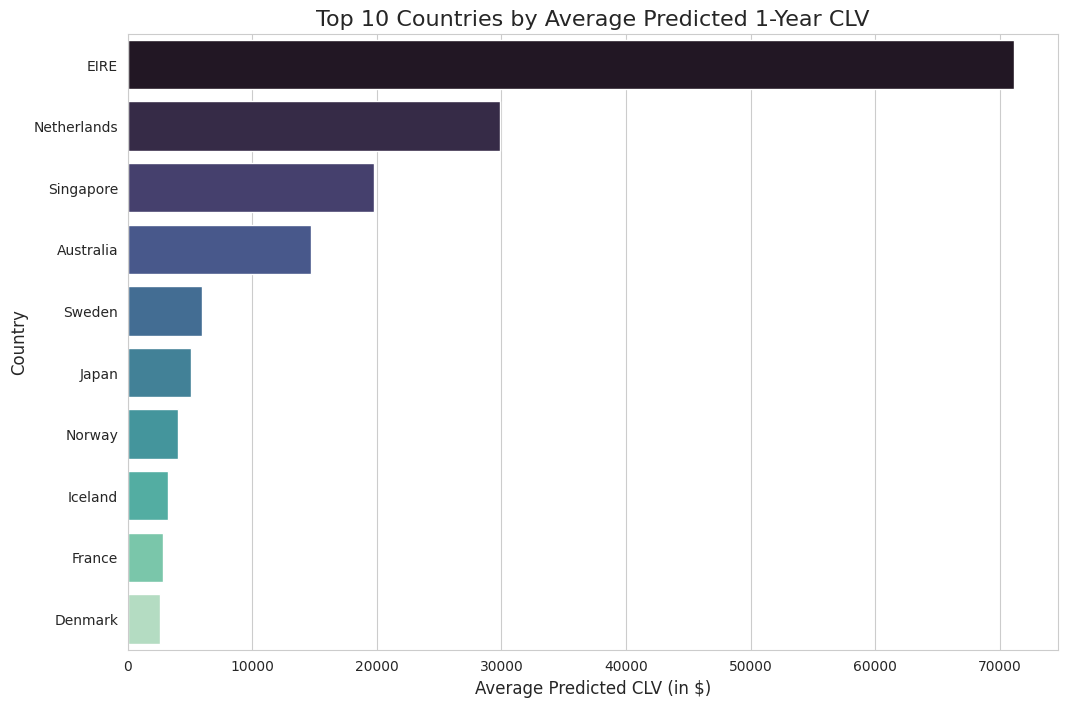

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Visualization 4: Average CLV by Country (Demographic Insight) ---

# Step 1: Get the 'Country' for each customer from the original dataframe 'df'.
# We drop duplicates to get a unique mapping of Customer ID to Country.
country_data = df[['Customer ID', 'Country']].drop_duplicates().set_index('Customer ID')

# Step 2: Join this country data with our CLV dataframe.
# Since both have 'Customer ID' as the index, a join is very efficient.
clv_with_country = clv_df.join(country_data)

# Step 3: Calculate the average CLV for the top 10 countries.
# We group by 'Country', calculate the mean of the CLV, sort descending, and take the top 10.
top_countries_avg_clv = clv_with_country.groupby('Country')['clv_1_year_discounted'].mean().sort_values(ascending=False).head(10)

# Step 4: Create the final bar plot.
plt.figure(figsize=(12, 8))
sns.barplot(
    x=top_countries_avg_clv.values,
    y=top_countries_avg_clv.index,
    palette='mako'  # A nice blue-green color palette
)

plt.title('Top 10 Countries by Average Predicted 1-Year CLV', fontsize=16)
plt.xlabel('Average Predicted CLV (in $)', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.show()